In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree

In [4]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=np.array([0.5, 0.1]),
    dt_base=0.002,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

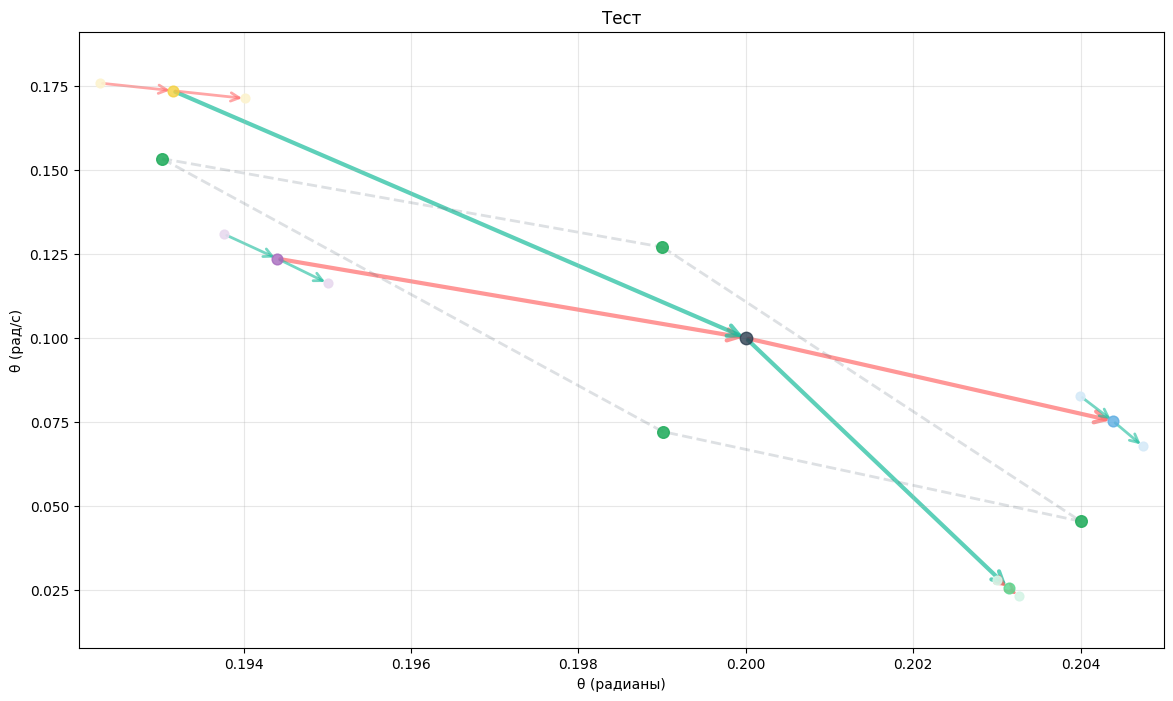

In [5]:
config_extreme = SporeTreeConfig(
    initial_position=np.array([0.2, 0.1]),
    dt_base=0.05,  # Очень большой шаг!
    dt_grandchildren_factor=1/10,  # Внуки в 2 раза меньше 
    show_debug=False
)


# Создаем дерево
tree = SporeTree(pendulum, config_extreme)

# Создаем всю структуру
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()


visualize_spore_tree(tree, "Тест")

In [6]:
# ───────── tree_evaluator.py ────────────────────────────────────────
class TreeEvaluator:
    def __init__(self, tree: SporeTree):
        self.tree = tree
        self._last_dt = None
        self._initialised = False     # порядок внуков ещё не зафиксирован

    # ---------------------------------------------------------------
    def _build_if_needed(self, dt_all: np.ndarray):
        dt_all = np.asarray(dt_all).ravel()

        if not self._initialised:
            # первый вызов → создаём детей, внуков, фиксируем порядок
            self.tree.create_children(dt_children=dt_all[:4])
            self.tree.create_grandchildren(dt_grandchildren=dt_all[4:])
            self.tree.sort_and_pair_grandchildren()
            self.tree.calculate_mean_points()
            self._initialised = True
        elif not np.allclose(dt_all, self._last_dt):
            # только обновляем позиции, порядок уже зафиксирован
            self.tree.update_positions(
                dt_children      = dt_all[:4],
                dt_grandchildren = dt_all[4:]
            )

        self._last_dt = dt_all.copy()

    # площадь четырёхугольника
    def area(self, dt_all: np.ndarray) -> float:
        self._build_if_needed(dt_all)
        mp = self.tree.mean_points           # (4,2)
        x, y = mp[:, 0], mp[:, 1]
        return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) -
                            np.dot(y, np.roll(x, 1)))

    # расстояния в 4 парах
    def pair_distances(self, dt_all: np.ndarray) -> np.ndarray:
        self._build_if_needed(dt_all)

        gc = self.tree.sorted_grandchildren  # ← всегда актуальный список
        d  = np.zeros(4)
        for k in range(4):
            i1, i2 = 2*k, 2*k+1
            p1 = gc[i1]['position']
            p2 = gc[i2]['position']
            d[k] = np.linalg.norm(p1 - p2)
        return d
# ────────────────────────────────────────────────────────────────────


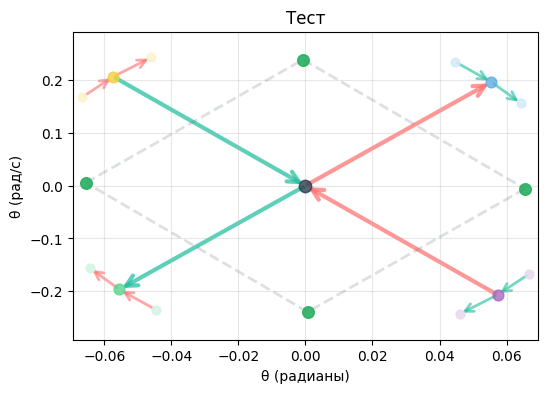

In [7]:
cfg = SporeTreeConfig(
    initial_position=np.array([0, 0.0]),
    dt_base=0.5,
    dt_grandchildren_factor=0.1,
    figure_size=(6, 4)
)

tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")

In [8]:
bounds = [(0.05, 0.6)]*4 + [(0.005, 0.06)]*8   # дети / внуки
init_guess = cfg.get_default_dt_vector()

C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.00018784234694476867
            Iterations: 21
            Function evaluations: 319
            Gradient evaluations: 21
pair distances: [0.001    0.001    0.001001 0.001   ]
area: 0.00018784234694476867


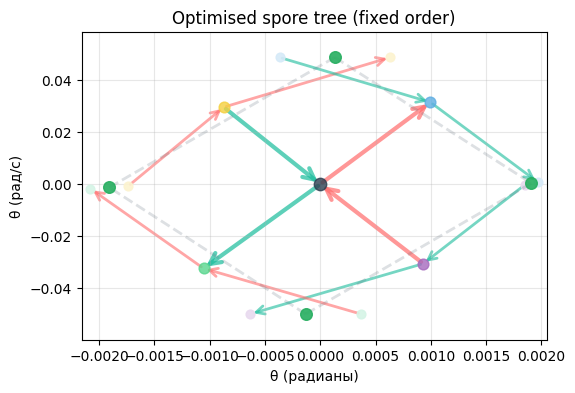

In [9]:
from scipy.optimize import minimize


evaluator = TreeEvaluator(tree)

def objective(dt_all):
    return -evaluator.area(dt_all)          # maximize area → minimise (-area)

epsilon = 1e-3
constraints = [
    {
        'type': 'ineq',
        'fun': (lambda idx: lambda v: epsilon - evaluator.pair_distances(v)[idx])(i)
    }
    for i in range(4)
]

result = minimize(objective, init_guess, method='SLSQP',
                  bounds=bounds, constraints=constraints,
                  options={'maxiter': 400, 'disp': True, 'eps': 1e-4})

print("pair distances:", np.round(evaluator.pair_distances(result.x), 6))
print("area:", -result.fun)
visualize_spore_tree(tree, title="Optimised spore tree (fixed order)")
